SRAG 2021 e 2022 - Banco de Dados de Síndrome Respiratória Aguda Grave - incluindo dados da COVID-19

Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import io
import requests
from sklearn.feature_selection import chi2
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings

Datasets

In [5]:
original_data_2022 = pd.read_csv('INFLUD22-26-09-2022.csv', delimiter=';', usecols = ['CS_SEXO','CS_RACA','SG_UF_NOT','UTI','RAIOX_RES','CS_ESCOL_N','CS_GESTANT','PUERPERA','CLASSI_FIN','VACINA_COV','CRITERIO','CARDIOPATI','RENAL','ASMA','DIABETES','HEMATOLOGI','SIND_DOWN','HEPATICA','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','OBESIDADE','OUT_MORBI','EVOLUCAO','DT_COLETA','NU_IDADE_N','FEBRE','TOSSE','GARGANTA','DISPNEIA','DESC_RESP','SATURACAO','DIARREIA','VOMITO','DOR_ABD','FADIGA','PERD_OLFT','PERD_PALA'])
original_data_2021 = pd.read_csv('INFLUD21-2021.csv', delimiter=';', usecols = ['CS_SEXO','CS_RACA','SG_UF_NOT','UTI','RAIOX_RES','CS_ESCOL_N','CS_GESTANT','PUERPERA','CLASSI_FIN','VACINA_COV','CRITERIO','CARDIOPATI','RENAL','ASMA','DIABETES','HEMATOLOGI','SIND_DOWN','HEPATICA','NEUROLOGIC','PNEUMOPATI','IMUNODEPRE','OBESIDADE','OUT_MORBI','EVOLUCAO','DT_COLETA','NU_IDADE_N','FEBRE','TOSSE','GARGANTA','DISPNEIA','DESC_RESP','SATURACAO','DIARREIA','VOMITO','DOR_ABD','FADIGA','PERD_OLFT','PERD_PALA'])

In [80]:
original_data_2022.shape

(447281, 38)

In [79]:
original_data_2021.shape

(1733517, 38)

In [7]:
data2022 = original_data_2022.copy(deep=True)
data2021 = original_data_2021.copy(deep=True)

Dataclean - 2021

In [11]:
#replace NAN values
data2021['CLASSI_FIN'].fillna(4, inplace = True)
data2021['CRITERIO'].fillna(0, inplace=True)
data2021['CS_GESTANT'].replace([0], 9, inplace=True) # Replace NANs with ignored values
data2021.fillna(9, inplace = True)

# Convert float columns to int
float_columns = data2021.select_dtypes(include='float').columns
data2021[float_columns] = data2021[float_columns].astype(int)

# Delimit dataset for pregnant and postpartum women
data2021['GRAVIDEZ'] = np.where(data2021['CS_GESTANT'].isin([1, 2, 3, 4]), data2021['CS_GESTANT'], 0)
data2021.loc[data2021['PUERPERA'] == 1, 'GRAVIDEZ'] = 5 # Defining that puerperal women receive 5 in the dataset

# Delimit dataset for confirmed COVID cases
data2021['COVID_LABORATORIAL'] = 0
data2021.loc[data2021['CLASSI_FIN'] == 5, 'COVID_LABORATORIAL'] = 5
data2021.loc[data2021['CRITERIO'] == 1, 'COVID_LABORATORIAL'] = 1

# Filter the dataset
data_temp2021 = data2021.loc[(data2021['GRAVIDEZ'] != 0) & (data2021['CLASSI_FIN'] == 5) & (data2021['CRITERIO'] == 1)].copy()
data_temp2021.reset_index(inplace=True, drop=True)

In [20]:
data_temp2021.describe()

,NU_IDADE_N,CS_GESTANT,CS_RACA,CS_ESCOL_N,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,...,CLASSI_FIN,CRITERIO,EVOLUCAO,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,VACINA_COV,GRAVIDEZ,COVID_LABORATORIAL
count,11464.000000,11464.000000,11464.000000,11464.000000,11464.000000,11464.000000,11464.000000,11464.000000,11464.000000,11464.000000,...,11464.0,11464.0,11464.000000,11464.000000,11464.000000,11464.000000,11464.000000,11464.000000,11464.000000,11464.0
mean,31.138259,3.123255,3.328681,6.313590,2.486479,2.005495,3.453507,2.277565,2.781664,2.784456,...,5.0,1.0,1.682746,3.886253,3.492760,3.703070,3.717725,4.727844,3.159020,1.0
std,9.283847,1.316284,2.546943,3.124111,2.708784,2.360819,3.114008,2.586492,2.928836,2.910878,...,0.0,0.0,2.019687,3.198781,3.200113,3.188914,3.185648,3.568926,1.204151,0.0
min,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
25%,25.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,5.0,1.0,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.0
50%,30.000000,3.000000,4.000000,9.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,...,5.0,1.0,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,1.0
75%,36.000000,3.000000,4.000000,9.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,5.0,1.0,1.000000,9.000000,2.000000,9.000000,9.000000,9.000000,4.000000,1.0
max,103.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,...,5.0,1.0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,5.000000,1.0


Dataclean - 2022

In [19]:
# Fill missing values
data2022['CLASSI_FIN'].fillna(4, inplace=True)
data2022['CRITERIO'].fillna(0, inplace=True)
data2022['CS_GESTANT'].replace([0], 9, inplace=True)
data2022.fillna(9, inplace=True)

# Convert float columns to int
float_columns_2022 = data2022.select_dtypes(include='float').columns
data2022[float_columns_2022] = data2022[float_columns_2022].astype(int)

# Delimit dataset for pregnant and postpartum women
data2022['GRAVIDEZ'] = np.where(data2022['CS_GESTANT'].isin([1, 2, 3, 4]), data2022['CS_GESTANT'], 0)
data2022.loc[data2022['PUERPERA'] == 1, 'GRAVIDEZ'] = 5

# Delimit dataset for confirmed COVID cases
data2022['COVID_LABORATORIAL'] = 0
data2022.loc[data2022['CLASSI_FIN'] == 5, 'COVID_LABORATORIAL'] = 5
data2022.loc[data2022['CRITERIO'] == 1, 'COVID_LABORATORIAL'] = 1

# Filter the dataset
data_temp2022 = data2022.loc[(data2022['GRAVIDEZ'] != 0) & (data2022['CLASSI_FIN'] == 5) & (data2022['CRITERIO'] == 1)].copy()
data_temp2022.reset_index(inplace=True, drop=True)

Concatenating the two DataFrames 

In [165]:
data_pre = pd.concat([data_temp2021,data_temp2022],ignore_index=True)
df_concat = data_pre.drop_duplicates(keep=False)
df_concat.reset_index(inplace = True, drop = True)
df_concat.loc[:, 'DT_COLETA'] = pd.to_datetime(df_concat['DT_COLETA'], format='%d/%m/%Y', errors='coerce')
df_concat = df_concat.dropna(subset=['DT_COLETA']).reset_index(drop=True) # remove rows (> 500) where the 'DT_COLETA' column has NaN values

C:\Users\User\AppData\Local\Temp\ipykernel_11456\2773814424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_concat.loc[:, 'DT_COLETA'] = pd.to_datetime(df_concat['DT_COLETA'], format='%d/%m/%Y', errors='coerce')
C:\Users\User\AppData\Local\Temp\ipykernel_11456\2773814424.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_concat.loc[:, 'DT_COLETA'] = pd.to_datetime(df_concat['DT_COLETA'], format='%d/%m/%Y', errors='coerce')


In [122]:
display(df_concat)

,SG_UF_NOT,CS_SEXO,NU_IDADE_N,CS_GESTANT,CS_RACA,CS_ESCOL_N,FEBRE,TOSSE,GARGANTA,DISPNEIA,...,CLASSI_FIN,CRITERIO,EVOLUCAO,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,VACINA_COV,GRAVIDEZ,COVID_LABORATORIAL
0,TO,F,39,1,4,9,2,2,2,1,...,5,1,2,2,1,2,2,2,1,1
1,AM,F,29,5,4,3,1,1,9,1,...,5,1,2,9,9,9,9,9,5,1
2,SP,F,59,5,1,9,2,2,2,1,...,5,1,1,2,2,2,2,9,5,1
3,MG,F,29,2,2,9,1,1,2,1,...,5,1,1,1,1,2,2,9,2,1
4,RO,F,30,2,4,3,1,1,2,2,...,5,1,9,2,2,2,2,9,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14848,DF,F,42,5,9,9,2,2,2,2,...,5,1,1,2,2,2,2,2,5,1
14849,MT,F,26,5,4,9,1,1,9,9,...,5,1,1,9,9,9,9,1,5,1
14850,SE,M,66,6,9,9,1,2,2,1,...,5,1,3,2,2,2,2,1,5,1
14851,SP,F,26,3,4,3,2,1,1,2,...,5,1,1,2,2,2,2,1,3,1


We considered the VOCs predominance period for:

Gama P.1 (March 2021 to Jul 2021);

Delta AY (Sept 2021 November 2021);

Omicrom BA (January 2022 aug 2022).



In [166]:
# Creating datasets that separate the variants
selecao_gama = (df_concat['DT_COLETA'] >= '2021-03-01') & (df_concat['DT_COLETA'] <= '2021-07-30')
selecao_delta= (df_concat['DT_COLETA'] >= '2021-09-01') & (df_concat['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df_concat['DT_COLETA'] >= '2022-01-01') & (df_concat['DT_COLETA'] <= '2022-08-30')

df_selection_gamma = df_concat[selecao_gama]
df_selection_delta = df_concat[selecao_delta]
df_selection_omicron = df_concat[selecao_omicrom]

print("Gamma sample: ", df_selection_gamma.shape)
print("Delta sample: ", df_selection_delta.shape)
print("Omicron sample: ", df_selection_omicron.shape)
print("Number of pregnant women: ", df_concat['GRAVIDEZ'].value_counts()[1] + df_concat['GRAVIDEZ'].value_counts()[2] + df_concat['GRAVIDEZ'].value_counts()[3] + df_concat['GRAVIDEZ'].value_counts()[4])
print("Number of postpartum women: ", df_concat['GRAVIDEZ'].value_counts()[5])
print()

# Creating a COVID variant variable
df_concat['VARIANTE_COVID'] = 0
df_concat.loc[selection_gamma, 'VARIANTE_COVID'] = 1
df_concat.loc[selection_delta, 'VARIANTE_COVID'] = 2
df_concat.loc[selection_omicron, 'VARIANTE_COVID'] = 3

df_concat = df_concat.loc[(df_concat['VARIANTE_COVID'] != 0)]
df_concat.reset_index(inplace=True, drop=True)
print("Final size of the dataframe: ", df_concat.shape)
print()

Gamma sample:  (8117, 40)
Delta sample:  (695, 40)
Omicron sample:  (3909, 40)
Number of pregnant women:  11148
Number of postpartum women:  3705

Final size of the dataframe:  (12721, 41)



Merge datasets to obtain region names

In [167]:
# Data URL (CSV file)
url = 'https://raw.githubusercontent.com/chandez/Estados-Cidades-IBGE/master/csv/estados.csv'

# Execute protocol to request data from a CSV file on the internet.
s = requests.get(url).content
file_name = io.StringIO(s.decode('utf-8'))
dm = pd.read_csv(url)

# Extracting the first 'table'
dm['Regiao_nome'] = dm['Regiao'] * 0
region_list = dm['Regiao'].tolist()

# Creating a mapping dictionary for region names
region_mapping = {1: 'North', 2: 'Northeast', 3: 'Southeast', 4: 'South', 5: 'Midwest'}

# Mapping the region names based on the 'Region' column
dm['Regiao_nome'] = dm['Regiao'].map(region_mapping)

dm = dm.drop(columns=['Nome', 'Id', 'CodigoUf'])
dm = dm.rename(columns={'Uf': 'SG_UF_NOT'})
df = df_concat.merge(dm, how='left', on='SG_UF_NOT')

lista_regiao_nome = df['Regiao_nome'].tolist()

Histograms

array([[<Axes: title={'center': 'NU_IDADE_N'}>,
        <Axes: title={'center': 'CS_GESTANT'}>,
        <Axes: title={'center': 'CS_RACA'}>,
        <Axes: title={'center': 'CS_ESCOL_N'}>,
        <Axes: title={'center': 'FEBRE'}>,
        <Axes: title={'center': 'TOSSE'}>],
       [<Axes: title={'center': 'GARGANTA'}>,
        <Axes: title={'center': 'DISPNEIA'}>,
        <Axes: title={'center': 'DESC_RESP'}>,
        <Axes: title={'center': 'SATURACAO'}>,
        <Axes: title={'center': 'DIARREIA'}>,
        <Axes: title={'center': 'VOMITO'}>],
       [<Axes: title={'center': 'PUERPERA'}>,
        <Axes: title={'center': 'CARDIOPATI'}>,
        <Axes: title={'center': 'HEMATOLOGI'}>,
        <Axes: title={'center': 'SIND_DOWN'}>,
        <Axes: title={'center': 'HEPATICA'}>,
        <Axes: title={'center': 'ASMA'}>],
       [<Axes: title={'center': 'DIABETES'}>,
        <Axes: title={'center': 'NEUROLOGIC'}>,
        <Axes: title={'center': 'PNEUMOPATI'}>,
        <Axes: title={'cent

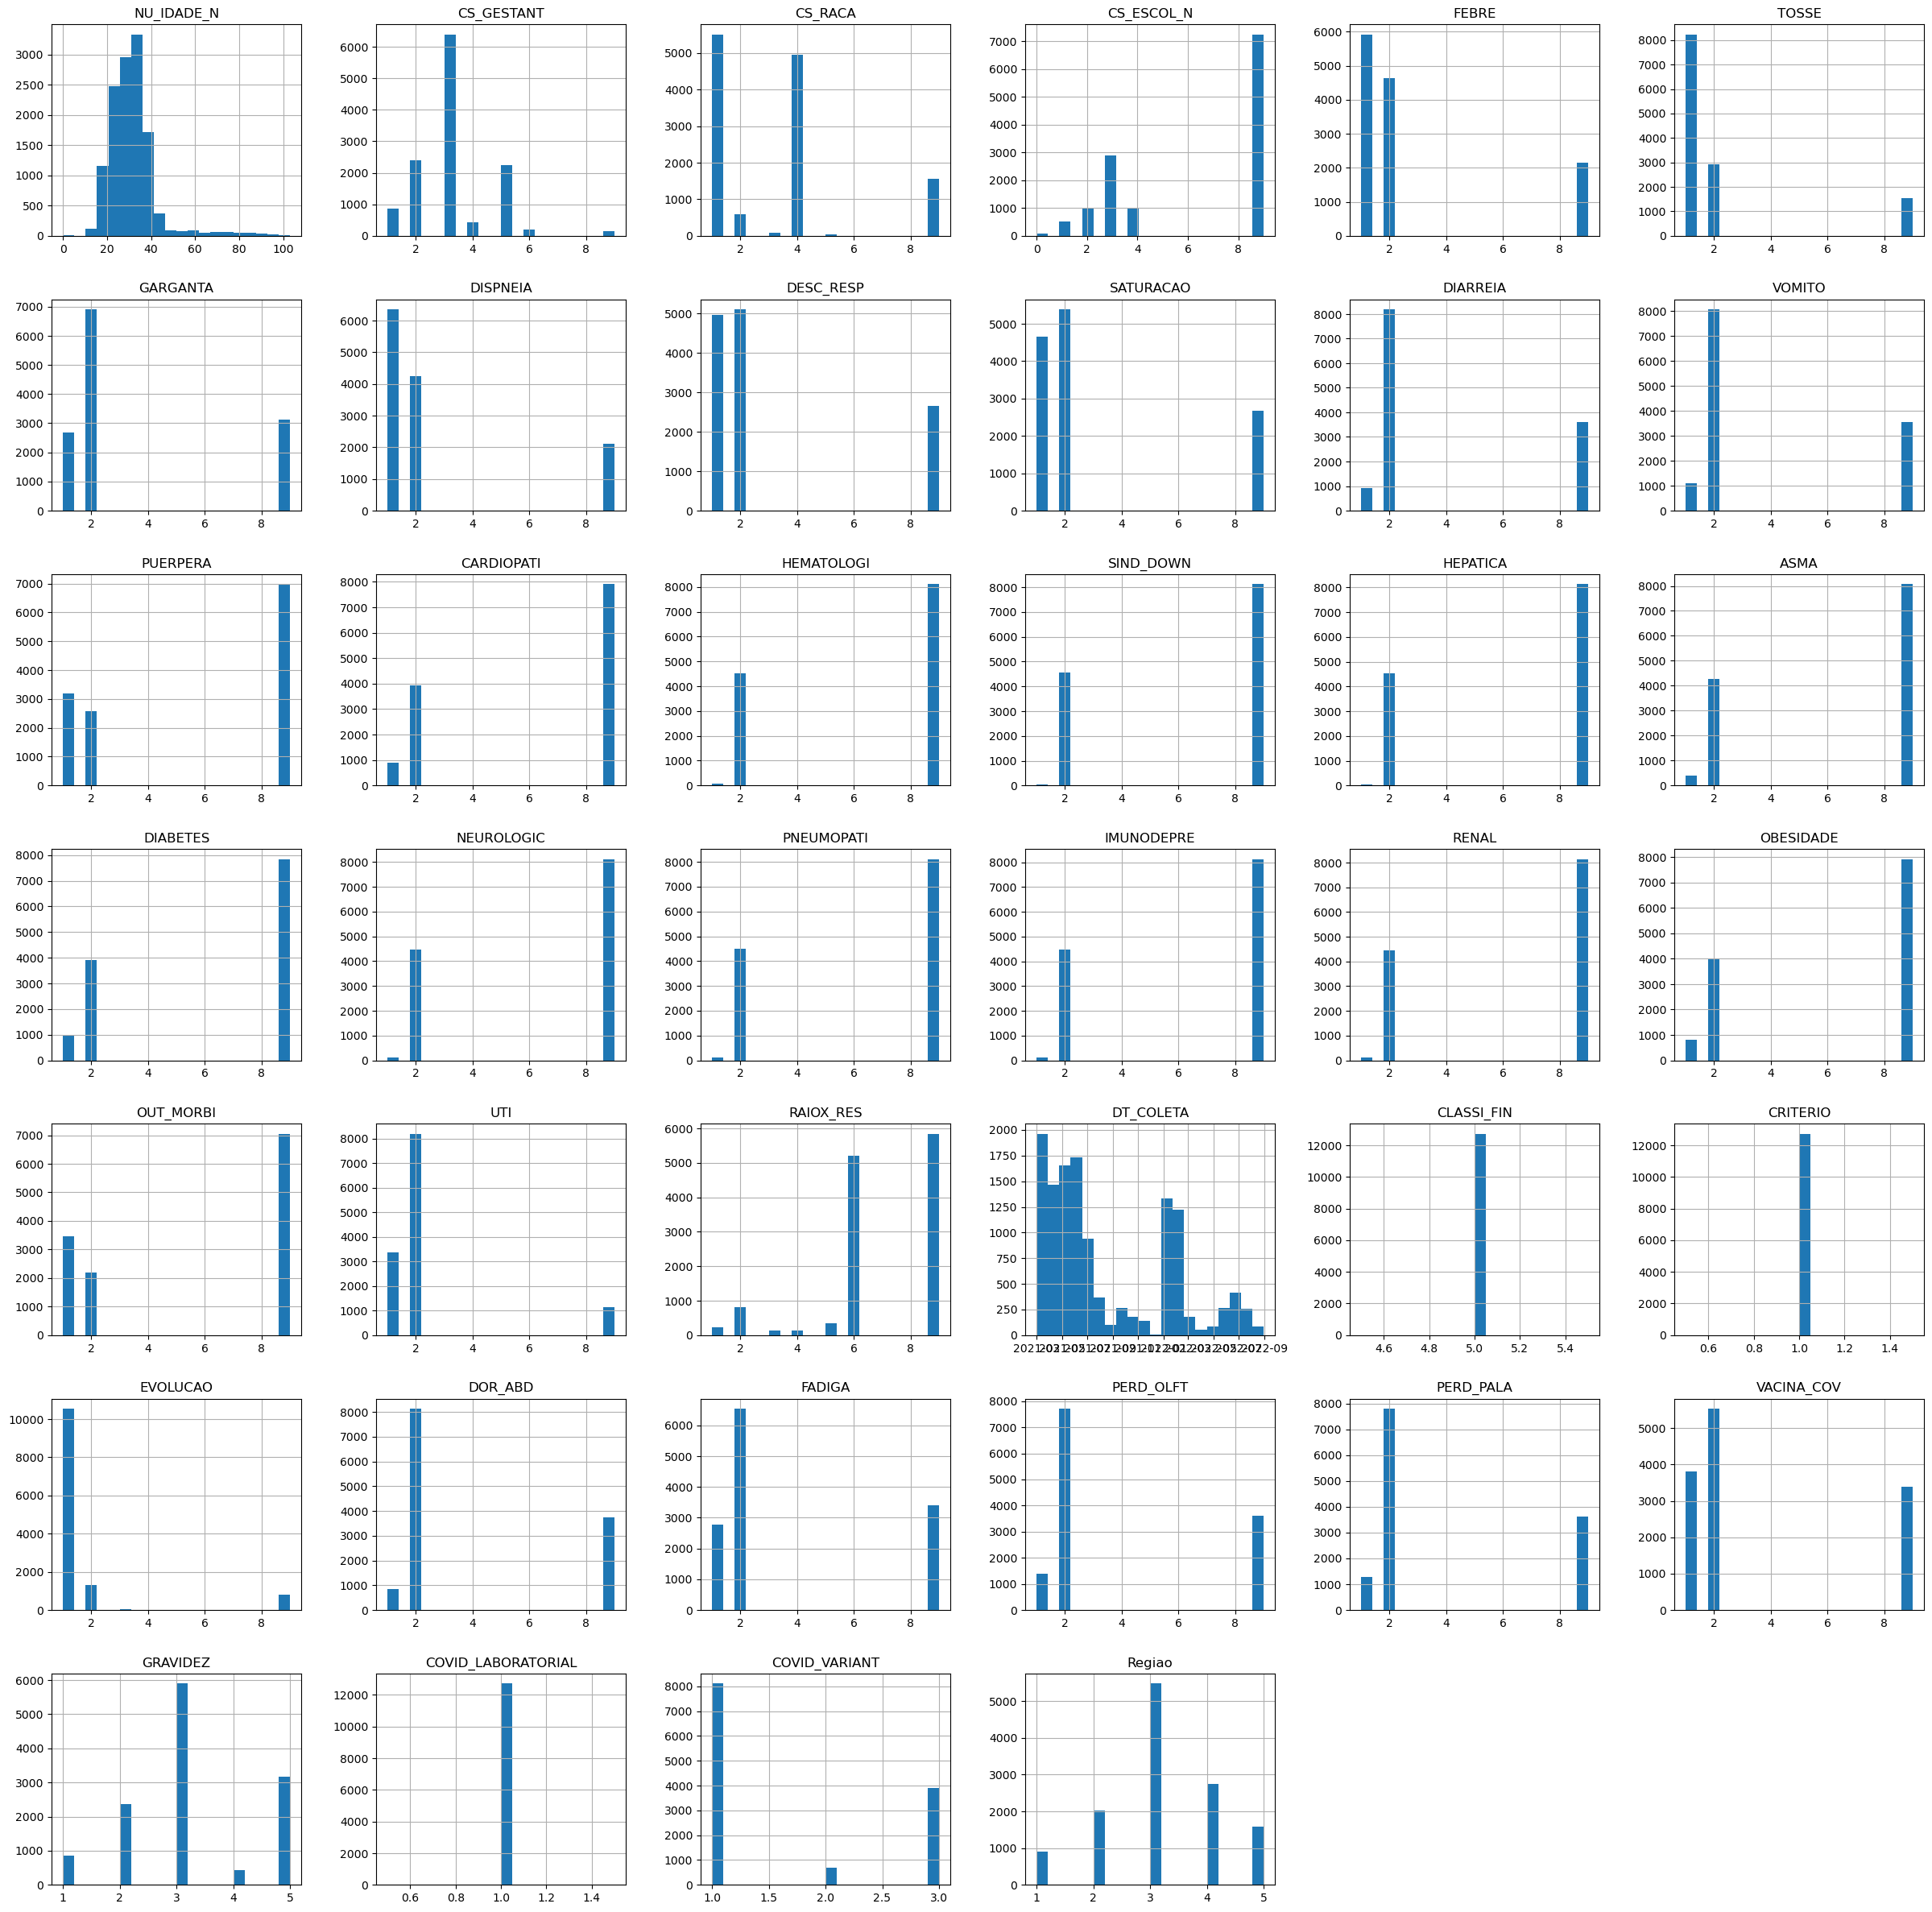

In [110]:
df[list(df.columns)].hist(bins=20, figsize=(30, 30))